<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/CNN/emo_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch CNN https://github.com/ppkgtmm/emotion.git emotion

In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, cnn
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [20]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Fixed('output_dim',128)
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
hp.Choice('log2_filter', [5, 6, 7])
hp.Choice('kernel_size', [3, 5])
hp.Fixed('pool_size', 2)
hp.Fixed('activation', 'relu')
seed = 1234

In [8]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
16347,id love to go shopping for sure because i am a...,anger
4487,i sit around and i feel disillusioned with school,sadness
3301,i feel ok and go out into the world to work bu...,joy
14182,i feel the cool in their wings as they brush m...,joy
443,i feel like im more hated than celebrated and ...,anger


In [9]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [10]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [11]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [21]:
tuner = BayesianOptimization( cnn.build_cnn,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/cnn_B32'
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4768)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 28614     
Total params: 1,960,934
Trainable params: 1,960,934
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = tuner.search(
            sequence_train, target_train,
            validation_split=0.1,
            epochs=4
)

Trial 12 Complete [00h 01m 47s]
val_accuracy: 0.8867647051811218

Best val_accuracy So Far: 0.9061764776706696
Total elapsed time: 00h 21m 45s
INFO:tensorflow:Oracle triggered exit


In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
output_dim (Fixed)
{'conditions': [], 'value': 128}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}
log2_filter (Choice)
{'default': 5, 'conditions': [], 'values': [5, 6, 7], 'ordered': True}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_size (Fixed)
{'conditions': [], 'value': 2}
activation (Fixed)
{'conditions': [], 'value': 'relu'}


In [24]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/cnn_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 128
optimizer: amsgrad
max_len: 300
num_words: 15000
log2_filter: 7
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.9061764776706696
Trial summary
Hyperparameters:
output_dim: 128
optimizer: adam
max_len: 300
num_words: 15000
log2_filter: 6
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.9038235247135162
Trial summary
Hyperparameters:
output_dim: 128
optimizer: amsgrad
max_len: 300
num_words: 15000
log2_filter: 6
kernel_size: 5
pool_size: 2
activation: relu
Score: 0.9017646908760071


In [25]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           20512     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 34, 128)           0

94/94 [==============================] - 0s 3ms/step
Accuracy:	90.5%


              precision    recall  f1-score   support

       anger       0.88      0.89      0.88       406
        fear       0.94      0.81      0.87       356
         joy       0.94      0.92      0.93      1014
        love       0.79      0.85      0.82       246
     sadness       0.95      0.96      0.95       870
    surprise       0.61      0.79      0.69       108

    accuracy                           0.91      3000
   macro avg       0.85      0.87      0.86      3000
weighted avg       0.91      0.91      0.91      3000



<Figure size 432x288 with 0 Axes>

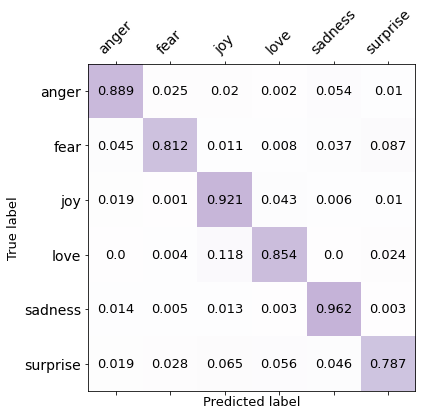

In [35]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [37]:
# best_model.save('best_cnn.h5')
# utils.dump(tokenizer, '/content/drive/MyDrive/__ed__/cnn_B32/tokenizer.pickle')

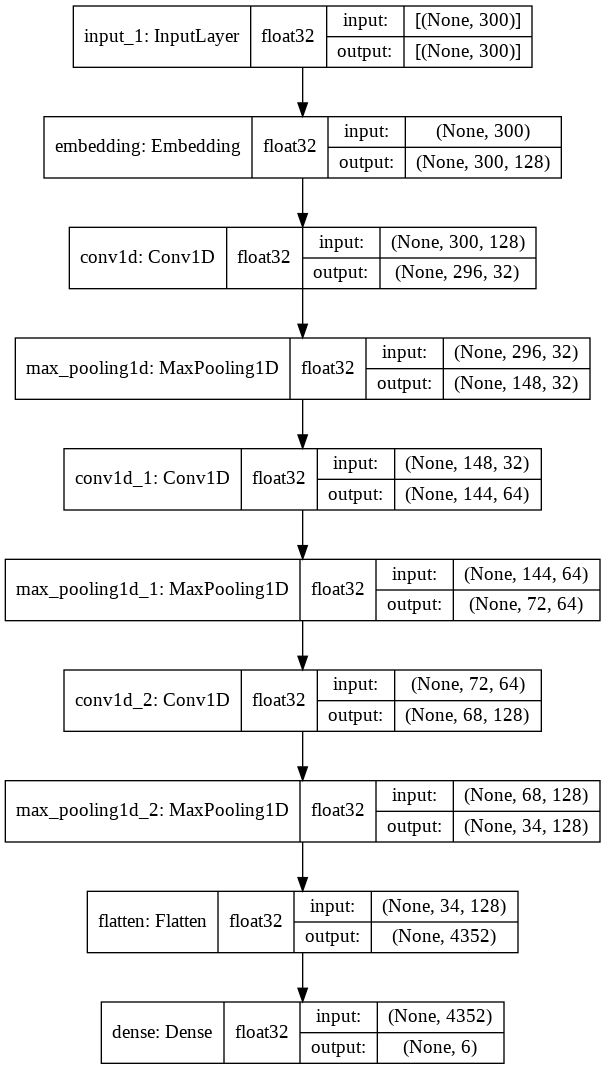

In [38]:
from keras.utils import plot_model
plot_model(
    best_model,
    to_file='/content/drive/MyDrive/__ed__/cnn_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )

In [27]:
model = cnn.build_cnn(tuner.get_best_hyperparameters(num_trials=1)[0])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 128)          1920000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 32)           20512     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 148, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 144, 64)           10304     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 72, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 68, 128)           41088     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 34, 128)          

In [28]:
cb = utils.get_callbacks('cnn_best.h5')

In [32]:
history = model.fit(
    sequence_train,
    target_train,
    validation_split=0.1,
    epochs=100,
    callbacks=cb
)

Epoch 1/100
479/479 [==============================] - 13s 28ms/step - loss: 0.0624 - accuracy: 0.9788 - precision_1: 0.9797 - recall_1: 0.9782 - val_loss: 0.3940 - val_accuracy: 0.8906 - val_precision_1: 0.8973 - val_recall_1: 0.8888

Epoch 00001: val_accuracy did not improve from 0.90176
Epoch 2/100
479/479 [==============================] - 14s 28ms/step - loss: 0.0428 - accuracy: 0.9857 - precision_1: 0.9860 - recall_1: 0.9854 - val_loss: 0.3965 - val_accuracy: 0.9076 - val_precision_1: 0.9122 - val_recall_1: 0.9041

Epoch 00002: val_accuracy improved from 0.90176 to 0.90765, saving model to cnn_best.h5
Epoch 3/100
479/479 [==============================] - 13s 28ms/step - loss: 0.0343 - accuracy: 0.9883 - precision_1: 0.9889 - recall_1: 0.9875 - val_loss: 0.4743 - val_accuracy: 0.9006 - val_precision_1: 0.9036 - val_recall_1: 0.8988

Epoch 00003: val_accuracy did not improve from 0.90765
Epoch 4/100
479/479 [==============================] - 13s 28ms/step - loss: 0.0295 - accuracy

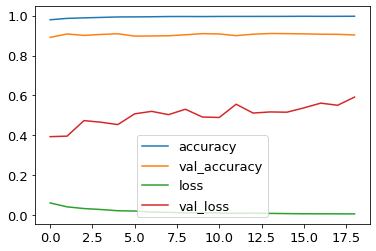

In [33]:
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
pd.DataFrame(history.history)[metr].plot()

94/94 [==============================] - 0s 3ms/step
Accuracy:	90.4%


              precision    recall  f1-score   support

       anger       0.90      0.89      0.89       406
        fear       0.91      0.83      0.87       356
         joy       0.92      0.93      0.93      1014
        love       0.77      0.79      0.78       246
     sadness       0.95      0.96      0.95       870
    surprise       0.73      0.77      0.75       108

    accuracy                           0.90      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.90      0.90      0.90      3000



<Figure size 432x288 with 0 Axes>

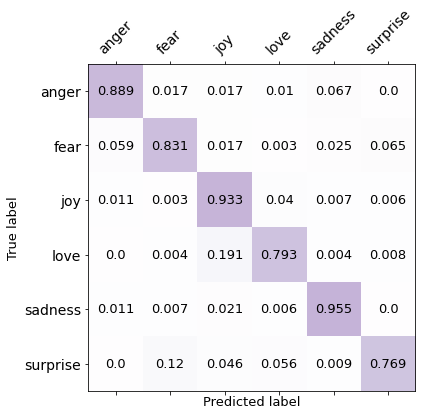

In [34]:
utils.model_evaluate(model, sequence_test, target_test, 32)